In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from math import exp, sqrt

In [2]:
rng = np.random.default_rng(34)

phi = np.concatenate([3*rng.beta(a=9, b=1.1, size=150000), rng.lognormal(mean=1.1, sigma=0.5, size=300000)])
phi = phi[phi > 0]

#psi = np.concatenate([rng.logistic(loc=2, scale=0.13, size=(phi<=2.8).sum()), 
#                  rng.normal(loc=6, scale=2, size=(60000-(phi<=2.5).sum()))])
psi = np.concatenate([rng.logistic(loc=2, scale=0.13, size=150000), 
                  rng.normal(loc=6, scale=2, size=(150000))])
psi[psi < 0] = 0

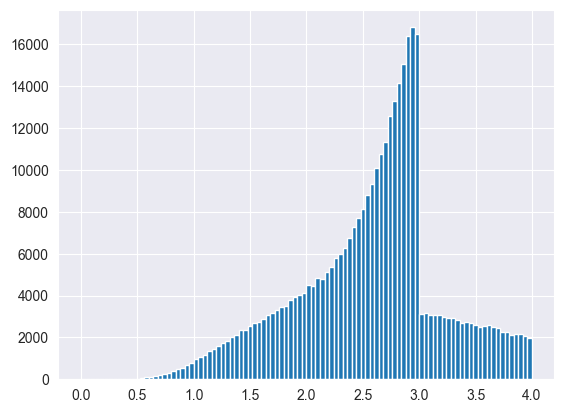

In [3]:
phi_hist = plt.hist(phi, bins=100, range=(0,4))


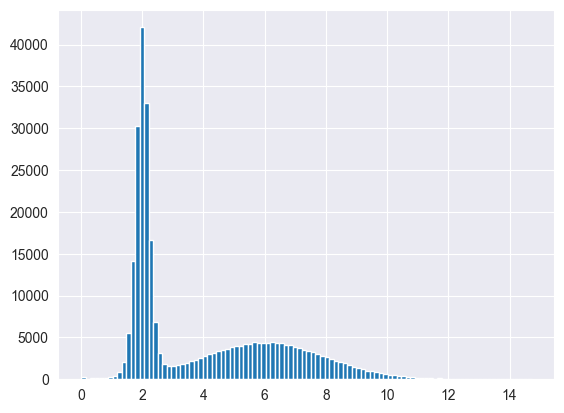

In [4]:
psi_hist = plt.hist(psi, bins=100)

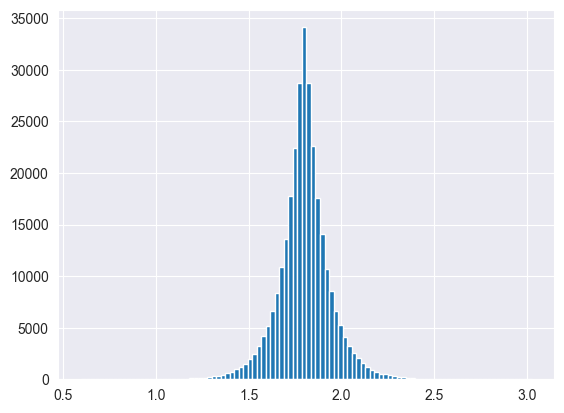

In [5]:
gamma = rng.laplace(loc=1.8, scale=0.1, size=300000)
gamma_hist = plt.hist(gamma, bins=100)

In [6]:
def f(phi, psi, gamma):
    return abs(1/(psi-3.0))-0.05*(psi-gamma)**2

In [7]:
phi0 = phi[phi<=2.95]
psi0 = psi[psi<=2.6]
print(len(phi0), len(psi0))
if len(phi0)>len(psi0):
    phi0, phi0_ = np.split(phi0, [len(psi0)])
elif len(phi0)<len(psi0):
    psi0, psi0_ = np.split(psi0, [len(phi0)])


gamma0, gamma0_ = np.split(gamma, [len(phi0)])
print(len(phi0), len(psi0), len(gamma0))

278600 155217
155217 155217 155217


In [8]:
dataframe0 = pd.DataFrame({'phi':phi0, 'psi':psi0, 'gamma':gamma0})

In [9]:
dataframe0['f'] = dataframe0.apply(lambda x: f(x['phi'], x['psi'], x['gamma']), axis=1)

<Axes: >

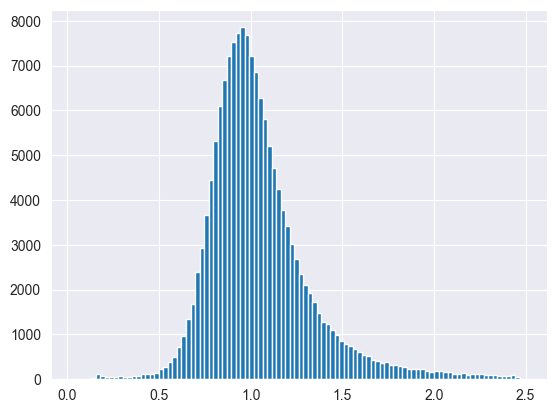

In [10]:
dataframe0['f'].hist(bins=100)

In [11]:
dataframe0.head()

,phi,psi,gamma,f
0,1.768889,1.756654,1.759562,0.804281
1,2.786787,2.022342,1.675197,1.016827
2,2.595872,1.838086,1.631689,0.858519
3,2.586989,1.836161,1.815590,0.859204
4,2.520131,1.909524,1.795573,0.916381


In [12]:
dataframe0.describe()

,phi,psi,gamma,f
count,155217.000000,155217.000000,155217.000000,155217.000000
mean,2.555696,1.984653,1.800081,1.045623
std,0.380782,0.263979,0.140710,0.285417
min,0.403625,0.000000,0.794290,0.032126
25%,2.406753,1.850110,1.730727,0.868510
50%,2.673295,1.997446,1.799868,0.994330
75%,2.831842,2.142612,1.869030,1.159271
max,2.949997,2.599986,3.005997,2.492068


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X0_traindf, X0_testdf, y0_traindf, y0_testdf = train_test_split(dataframe0[['phi','psi','gamma']], dataframe0['f'], train_size=0.7,
                                                            shuffle=True)

scaler = StandardScaler()
X0_train = scaler.fit_transform(X=X0_traindf)
X0_test = scaler.transform(X=X0_testdf)
y0_train = y0_traindf.values
y0_test = y0_testdf.values

X0_valdf, X0_proddf, y0_valdf, y0_proddf = train_test_split(X0_testdf, y0_testdf, train_size=0.7,
                                                            shuffle=True)
X0_val = scaler.transform(X=X0_valdf)
X0_prod = scaler.transform(X=X0_proddf)
y0_val = y0_valdf.values
y0_prod = y0_proddf.values

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

X_0train = torch.tensor(X0_train, dtype=torch.float32)
X_0val = torch.tensor(X0_val, dtype=torch.float32)
y_0train = torch.tensor(y0_train, dtype=torch.float32)
y_0val = torch.tensor(y0_val, dtype=torch.float32)

In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(ANN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, 1)

    def forward(self, input):
        out = F.relu(self.linear1(input))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        return out

In [16]:
# select loss and optimizers
model = ANN(X_0train.shape[1], 10, 7)
model.apply(init_weights)

loss = nn.L1Loss() # loss function
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)


# training the model:

num_of_epochs=100
for i in range(num_of_epochs):
    model.train()
    # give the input data to the architecure
    y_pred = model(X_0train)
    train_loss = loss(y_pred.squeeze(),y_0train)   # find the loss function:
    optimizer.zero_grad() # make gradients zero for every iteration so next iteration it will be clear
    train_loss.backward()  # back propagation
    optimizer.step()  # update weights in NN
    scheduler.step()

    with torch.no_grad():
      model.eval()   # make model in evaluation stage
      y_pred=model(X_0val)
      test_loss=loss(y_pred.squeeze(),y_0val)
        
    # print the loss in training part:
    if i % 10 == 0:
        print(f'[epoch:{i}]: Train MAE = {train_loss}')
        print(f'Test MAE = {test_loss.item():.4f}')


[epoch:0]: Train MAE = 0.8669693470001221
Test MAE = 0.5721
[epoch:10]: Train MAE = 0.11469189822673798
Test MAE = 0.0902
[epoch:20]: Train MAE = 0.05716758593916893
Test MAE = 0.0489
[epoch:30]: Train MAE = 0.040159206837415695
Test MAE = 0.0386
[epoch:40]: Train MAE = 0.03409218043088913
Test MAE = 0.0344
[epoch:50]: Train MAE = 0.029602348804473877
Test MAE = 0.0297
[epoch:60]: Train MAE = 0.02794858254492283
Test MAE = 0.0278
[epoch:70]: Train MAE = 0.02650545723736286
Test MAE = 0.0266
[epoch:80]: Train MAE = 0.0256671030074358
Test MAE = 0.0258
[epoch:90]: Train MAE = 0.024995215237140656
Test MAE = 0.0251


In [17]:
import nannyml as nml

In [18]:
reference_df = X0_valdf.copy()
reference_df['f'] = y0_valdf
reference_df['preds'] = y_pred.squeeze().numpy()

reference_df.head()

,phi,psi,gamma,f,preds
129023,2.825941,2.307819,1.591480,1.419052,1.399017
5349,2.899040,1.970000,1.928762,0.970789,0.975624
99621,2.855639,1.888757,1.624137,0.896392,0.898263
107037,2.084519,1.469728,1.619029,0.652364,0.646126
144386,2.135637,1.769622,1.794631,0.812727,0.813369


In [19]:
estimator = nml.DLE(
    feature_column_names=['phi','psi','gamma'],
    y_pred='preds',
    y_true='f',
    metrics=['mae'],
    chunk_number=100,
    tune_hyperparameters=False
)
estimator.fit(reference_df)

/Users/sebasmos/anaconda3/envs/book/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [20]:
len(reference_df)

32596

In [21]:
prod_df0 = X0_proddf.copy()
prod_df0['f'] = y0_proddf
with torch.no_grad():
    model.eval()
    y_pred_prod0 = model(torch.tensor(X0_prod, dtype=torch.float32))
prod_df0['preds'] = y_pred_prod0.squeeze().numpy()
                     
len(prod_df0)

13970

In [22]:
estimated_performance = estimator.estimate(prod_df0)
estimated_performance.plot()

In [23]:
phi1 = phi[phi>=3.05]
psi1 = psi[psi>2.6]
print(len(phi1), len(psi1))
if len(phi1)>len(psi1):
    phi1, phi1_ = np.split(phi1, [len(psi1)])
elif len(phi1)<len(psi1):
    psi1, psi1_ = np.split(psi1, [len(phi1)])


#gamma0, gamma0_ = np.split(gamma, [len(phi0)])
print(len(phi1), len(psi1), len(gamma0_))

146664 144783
144783 144783 144783


In [24]:
proddf_shuffled = prod_df0.sample(frac=1)
proddf_0, proddf_f = np.array_split(proddf_shuffled, 2)

In [25]:
proddf_0.head()

,phi,psi,gamma,f,preds
109815,2.430205,2.022983,1.784450,1.020679,1.010519
39210,2.862637,2.438340,1.676599,1.751424,1.590827
41186,2.691641,2.201389,1.642117,1.236534,1.253157
77728,1.749664,2.013727,1.682922,1.008446,1.001890
41343,2.658223,1.949349,1.779920,0.950355,0.935024


In [26]:
proddf_0.reset_index(drop=True, inplace=True)
proddf_f.reset_index(drop=True, inplace=True)

In [27]:
proddf_middle = pd.DataFrame({'phi':phi1, 'psi':psi1, 'gamma':gamma0_})
proddf_middle['f'] = proddf_middle.apply(lambda x: f(x['phi'], x['psi'], x['gamma']), axis=1)

Xmiddle_prod = proddf_middle.loc[:,['phi', 'psi', 'gamma']]
Xmiddle_prod = scaler.transform(Xmiddle_prod)
with torch.no_grad():
    model.eval()
    y_pred_proddf = model(torch.tensor(Xmiddle_prod, dtype=torch.float32))
proddf_middle['preds'] = y_pred_proddf.squeeze().numpy()

In [28]:
proddf_middle.head()

,phi,psi,gamma,f,preds
0,3.731725,2.852260,1.846763,6.718085,2.055231
1,6.462316,2.699592,1.824676,3.290527,2.219100
2,4.839688,2.856941,1.650035,6.917310,2.006789
3,5.707916,2.617136,1.856435,2.582963,1.944224
4,4.294394,2.628281,1.709035,2.647955,1.677232


In [29]:
proddf_middle.describe()

,phi,psi,gamma,f,preds
count,144783.000000,144783.000000,144783.000000,1.447830e+05,144783.000000
mean,4.744957,6.156721,1.799937,8.384283e+00,6.173345
std,1.684075,1.841423,0.142128,2.878032e+03,2.278666
min,3.050008,2.600032,0.595185,-8.296996e+00,1.594862
25%,3.563775,4.801348,1.730353,-1.342952e+00,4.492193
50%,4.251740,6.083787,1.799895,-5.928227e-01,6.068572
75%,5.376025,7.400240,1.869753,1.064121e-01,7.704278
max,25.205534,14.732552,3.028360,1.094105e+06,17.044109


In [30]:
production_df = pd.concat([proddf_0, proddf_middle.sample(frac=0.1), proddf_f], ignore_index=True)

In [31]:
estimated_performance = estimator.estimate(production_df)
estimated_performance.plot()

In [32]:
drdc = nml.DataReconstructionDriftCalculator(column_names=['phi','psi','gamma'],
                                             chunk_number=100)

drdc.fit(reference_df)
multivariate_data_drift = drdc.calculate(prod_df0)

In [33]:
multivariate_data_drift.plot()

In [34]:
multivariate_data_drift = drdc.calculate(production_df)
multivariate_data_drift.plot()

In [35]:
from river import stream, evaluate, metrics, preprocessing, neural_net, optim, datasets

In [36]:
online_model = (preprocessing.StandardScaler() |
    neural_net.MLPRegressor(
        hidden_dims=(10, 7),
        activations=(
            neural_net.activations.ReLU,
            neural_net.activations.ReLU,
            neural_net.activations.Identity),
        optimizer=optim.Adam(lr=0.01),
        loss=optim.losses.Absolute(),
        seed=42))

metric = metrics.MAE()

In [37]:
full_dataset = pd.concat([pd.concat([X0_traindf, y0_traindf], axis=1), pd.concat([X0_valdf, y0_valdf], axis=1), production_df.drop(columns='preds')], ignore_index=True)
full_dataset.head()

,phi,psi,gamma,f
0,2.415489,2.479991,1.838660,1.902478
1,2.828431,2.456262,1.835980,1.819885
2,2.531951,1.832754,2.024653,0.854876
3,2.842074,2.125795,1.773785,1.137701
4,2.937356,2.211652,1.795884,1.259832


In [38]:
Xon = full_dataset[['phi','psi','gamma']]
yon = full_dataset['f']

In [39]:
class online_dataset(datasets.base.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        super().__init__(
            task='Regression',
            n_samples=len(self.X),
            n_features=len(self.X.columns)
        )

    def __iter__(self):
        return stream.iter_pandas(self.X, self.y)

dataseton = online_dataset(Xon, yon)

In [40]:
preds = []
for X, y in dataseton:
    y_pred = online_model.predict_one(X)
    metric = metric.update(y, y_pred)
    online_model = online_model.learn_one(X, y)
    preds.append(y_pred)

In [41]:
full_dataset['preds']=preds
full_dataset.head(100)

,phi,psi,gamma,f,preds
0,2.415489,2.479991,1.838660,1.902478,0.000000
1,2.828431,2.456262,1.835980,1.819885,-0.006442
2,2.531951,1.832754,2.024653,0.854876,-0.669751
3,2.842074,2.125795,1.773785,1.137701,0.032189
4,2.937356,2.211652,1.795884,1.259832,0.043566
...,...,...,...,...,...
95,2.878984,1.973761,1.881523,0.974006,0.831431
96,2.412906,2.070049,1.554713,1.062047,0.975419
97,2.816471,1.813150,1.784092,0.842524,0.803472
98,2.521650,1.691555,1.675155,0.764252,0.682100


In [42]:
full_dataset.iloc[len(X0_traindf):len(X0_traindf)+len(X0_valdf)]

,phi,psi,gamma,f,preds
108651,2.825941,2.307819,1.591480,1.419052,1.493925
108652,2.899040,1.970000,1.928762,0.970789,0.946764
108653,2.855639,1.888757,1.624137,0.896392,0.883011
108654,2.084519,1.469728,1.619029,0.652364,0.615040
108655,2.135637,1.769622,1.794631,0.812727,0.806728
...,...,...,...,...,...
141242,2.797069,2.120980,1.893700,1.135048,1.138659
141243,2.684043,2.246878,1.941956,1.323158,1.335536
141244,2.714353,2.278571,1.535221,1.358510,1.281433
141245,2.678943,2.153488,1.764818,1.173765,1.144183


In [43]:
estimator = nml.DLE(
    feature_column_names=['phi','psi','gamma'],
    y_pred='preds',
    y_true='f',
    metrics=['mae'],
    chunk_number=100,
    tune_hyperparameters=False
)
estimator.fit(full_dataset.iloc[len(X0_traindf):len(X0_traindf)+len(X0_valdf)])

/Users/sebasmos/anaconda3/envs/book/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



In [ ]:
estimated_performance = estimator.estimate(full_dataset.iloc[len(X0_traindf)+len(X0_valdf):])
estimated_performance.plot()